## 問題１ (ロジスティック回帰の練習) 
今回説明した手法を使って、ロジスティック回帰の練習をしましょう。まず自分で何らかのデータセットを用意します（webから分類向きのデータを検索）。そして、そのデータの前処理、モデルの学習、ベストなモデルの選択、テスト性能の評価までを一通り行いましょう。また単純なベースラインモデルの性能も提示することで、工夫が性能向上にどれくらい効いたかがわかるようにしましょう。また、モデルの改善に関しては自由研究課題も参考にしてみてください。

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from google.colab import drive

## 肺がんデータセット
X肺がん手術後の平均余命に関するデータから成る。データは2007年から2011 年に原発性肺癌の主要な肺切除を受けた患者に関するもので、ヴロツワフ胸部 外科センター(ポーランド)で収集された。17 個の属性を持つ 470 個のインス タンス。属性: 肺活量、ぜんそく、喫煙、手術時の年齢、末梢動脈疾患など。 各データは2つのクラスにいずれかに属する: クラス 1 – 外科手術後 1 年以 内に死亡、クラス2 – 生存。　\
当該データセットは次のサイトから入手できる: https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data

Attribute Information:

1. DGN: Diagnosis - specific combination of ICD-10 codes for primary and secondary as well multiple tumours if any (DGN3,DGN2,DGN4,DGN6,DGN5,DGN8,DGN1) 
2. PRE4: Forced vital capacity - FVC (numeric) 
3. PRE5: Volume that has been exhaled at the end of the first second of forced expiration - FEV1 (numeric) 
4. PRE6: Performance status - Zubrod scale (PRZ2,PRZ1,PRZ0) 
5. PRE7: Pain before surgery (T,F) 
6. PRE8: Haemoptysis before surgery (T,F) 
7. PRE9: Dyspnoea before surgery (T,F) 
8. PRE10: Cough before surgery (T,F) 
9. PRE11: Weakness before surgery (T,F) 
10. PRE14: T in clinical TNM - size of the original tumour, from OC11 (smallest) to OC14 (largest) (OC11,OC14,OC12,OC13) 
11. PRE17: Type 2 DM - diabetes mellitus (T,F) 
12. PRE19: MI up to 6 months (T,F) 
13. PRE25: PAD - peripheral arterial diseases (T,F) 
14. PRE30: Smoking (T,F) 
15. PRE32: Asthma (T,F) 
16. AGE: Age at surgery (numeric) 
17. Risk1Y: 1 year survival period - (T)rue value if died (T,F) 



## データの前処理

In [2]:
drive.mount('/content/drive')
home_path = '/content/drive/My Drive/MachineLearning/Second/'

# データの列名を設定する
colums=["Diagnosis","FVC","FEV1","Performance","Pain","Haemoptysis","Dyspnoea","Cough","Weakness",
        "Tumor_Size","Diabetes_Mellitus","MI_6mo","PAD","Smoking","Asthma","Age","Death_1yr"]

# データを読み込み
thoraricSurgery = pd.read_csv(home_path+"ThoraricSurgery.csv", skiprows=21, names=colums)

thoraricSurgery.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age,Death_1yr
0,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
1,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
2,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
3,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
4,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T


In [3]:
# 欠損値を確認
thoraricSurgery.isna().sum()

Diagnosis            0
FVC                  0
FEV1                 0
Performance          0
Pain                 0
Haemoptysis          0
Dyspnoea             0
Cough                0
Weakness             0
Tumor_Size           0
Diabetes_Mellitus    0
MI_6mo               0
PAD                  0
Smoking              0
Asthma               0
Age                  0
Death_1yr            0
dtype: int64

In [4]:
# "Diagnosis","Performance","Tumor_Size"のユニークな要素を表示する
print("Diagnosis", thoraricSurgery["Diagnosis"].unique())
print("Performance", thoraricSurgery["Performance"].unique())
print("Tumor_Size", thoraricSurgery["Tumor_Size"].unique())

Diagnosis ['DGN2' 'DGN3' 'DGN4' 'DGN8' 'DGN5' 'DGN6' 'DGN1']
Performance ['PRZ1' 'PRZ0' 'PRZ2']
Tumor_Size ['OC14' 'OC12' 'OC11' 'OC13']


In [5]:
# T/F,DGNXX,PRZXXX,OC1XXXは数字に置き換える
thoraricSurgery = thoraricSurgery.replace({"F":0, "T":1, 
                                           "DGN1":1, "DGN2":2, "DGN3":3, "DGN4":4, "DGN5":5, "DGN6":6, "DGN8":8,
                                           "PRZ0":0, "PRZ1":1, "PRZ2":2, 
                                           "OC11":1, "OC12":2, "OC13":3, "OC14":4})

thoraricSurgery

,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age,Death_1yr
0,2,2.88,2.16,1,0,0,0,1,1,4,0,0,0,1,0,60,0
1,3,3.40,1.88,0,0,0,0,0,0,2,0,0,0,1,0,51,0
2,3,2.76,2.08,1,0,0,0,1,0,1,0,0,0,1,0,59,0
3,3,3.68,3.04,0,0,0,0,0,0,1,0,0,0,0,0,54,0
4,3,2.44,0.96,2,0,1,0,1,1,1,0,0,0,1,0,73,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2,3.88,2.12,1,0,0,0,1,0,3,0,0,0,1,0,63,0
466,3,3.76,3.12,0,0,0,0,0,0,1,0,0,0,1,0,61,0
467,3,3.04,2.08,1,0,0,0,1,0,3,0,0,0,0,0,52,0
468,3,1.96,1.68,1,0,0,0,1,1,2,0,0,0,1,0,79,0


## テストデータ生成

In [6]:
# 説明変数と目的変数を生成する
X = thoraricSurgery.iloc[:, :16]
y = thoraricSurgery.iloc[:, 16]

print(X.shape)
print(y.shape)

(470, 16)
(470,)


In [7]:
# 訓練データとテストデータを生成する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

In [8]:
# 標準化
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## L1とL2正則化のモデル生成と訓練

In [9]:
Cs = [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001] # リスト内包表記で書き直して見ましょう！
scores_l1 = []
coefs_and_Cs_l1 = []

scores_l2 = []
coefs_and_Cs_l2 = []

for C in Cs:
    # L1正規化のモデルを作成
    clf_l1 = LogisticRegression(C=C, penalty='l1', solver='liblinear')
    clf_l1.fit(X_train_scaled, y_train)
    scores_l1.append(clf_l1.score(X_test_scaled, y_test))
    coefs_and_Cs_l1.append((np.squeeze(clf_l1.coef_),C))
    
    # L2正規化のモデルを作成
    clf_l2 = LogisticRegression(C=C, penalty='l2')
    clf_l2.fit(X_train_scaled, y_train)
    scores_l2.append(clf_l2.score(X_test_scaled, y_test))
    coefs_and_Cs_l2.append((np.squeeze(clf_l2.coef_),C))

## 考査

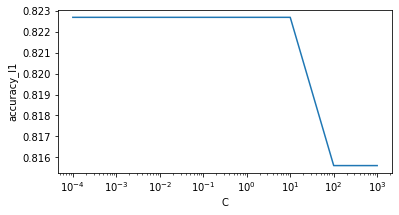

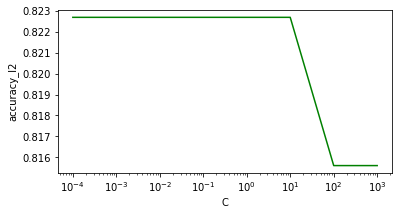

In [10]:
# それぞれC値について、L1とL2のスーコアを表示
for i in range(2):
    if i == 0:
        # L1正規化のモデル
        plt.figure(figsize=(6,3))
        plt.plot(Cs,scores_l1)
        plt.xlabel('C')
        plt.ylabel('accuracy_l1')
        plt.xscale('log')
    if i == 1:
        # L2正規化のモデル
        plt.figure(figsize=(6,3))
        plt.plot(Cs,scores_l2, color="green")
        plt.xlabel('C')
        plt.ylabel('accuracy_l2')
        plt.xscale('log')

In [11]:
# それぞれC値について、大きな寄与を与えている特徴量トップ5を見て見ましょう
def get_top5_feature_names(coef):
    for i in range(len(coef)):
        C = coef[i][1]
        top5_name = []
        
        for j in range(1,6):
            idx = np.argsort(np.abs(coef[i][0]))[-j]
            top5_name.append(colums[idx])
        
        print(("C"+str(C)).ljust(7),":",top5_name)

In [12]:
# それぞれC値について、L1モデルの特徴量トップ5
get_top5_feature_names(coefs_and_Cs_l1)

C1000   : ['MI_6mo', 'Diagnosis', 'Asthma', 'Tumor_Size', 'Smoking']
C100    : ['Diagnosis', 'MI_6mo', 'Tumor_Size', 'Smoking', 'Asthma']
C10     : ['Diagnosis', 'Tumor_Size', 'MI_6mo', 'Smoking', 'Dyspnoea']
C1      : ['Tumor_Size', 'Smoking', 'Haemoptysis', 'Weakness', 'Dyspnoea']
C0.1    : ['Age', 'Asthma', 'Smoking', 'PAD', 'MI_6mo']
C0.01   : ['Age', 'Asthma', 'Smoking', 'PAD', 'MI_6mo']
C0.001  : ['Age', 'Asthma', 'Smoking', 'PAD', 'MI_6mo']
C0.0001 : ['Age', 'Asthma', 'Smoking', 'PAD', 'MI_6mo']


In [13]:
# それぞれC値について、L2モデルの特徴量トップ5
get_top5_feature_names(coefs_and_Cs_l2)

C1000   : ['MI_6mo', 'Diagnosis', 'Asthma', 'Tumor_Size', 'Smoking']
C100    : ['Diagnosis', 'MI_6mo', 'Tumor_Size', 'Smoking', 'Asthma']
C10     : ['Diagnosis', 'Tumor_Size', 'MI_6mo', 'Smoking', 'Dyspnoea']
C1      : ['Tumor_Size', 'Diagnosis', 'Smoking', 'Dyspnoea', 'Haemoptysis']
C0.1    : ['Tumor_Size', 'Smoking', 'Haemoptysis', 'Cough', 'Dyspnoea']
C0.01   : ['Smoking', 'Tumor_Size', 'Cough', 'Haemoptysis', 'Weakness']
C0.001  : ['Smoking', 'Tumor_Size', 'Cough', 'Haemoptysis', 'Weakness']
C0.0001 : ['Smoking', 'Tumor_Size', 'Cough', 'Haemoptysis', 'Weakness']


L1モデルの特徴量トップ5から見ると、C0.1から小さくても、特徴量は変わらないです。年齢とか、喘息とか、喫煙とか、寄与率が高いです。
L2モデルの特徴量トップ5から見ると、C0.01から小さくても、特徴量は変わらないです。喫煙とか、腫瘍サイズとか、咳とか、寄与率が高いです。
上記の項目値は高くと、病気になる可能性は高いです。一般的に考えると、結果は合っていると思います。